## Classification using siamese model

In [1]:
import keras
from tensorflow.contrib.tensorboard.plugins import projector

C:\Users\Thiago\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import re
import numpy as np
import pandas as pd

import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%matplotlib inline

In [3]:
from methods.baseline import Baseline

In [4]:
from keras.layers import Conv1D, Input, Add, Activation, Dropout, Embedding, MaxPooling1D, GlobalMaxPool1D, Flatten, Dense, Concatenate, BatchNormalization
from keras.models import Model

## Configurações Globais

In [5]:
MAX_SEQUENCE_LENGTH_T = 100 # 40
MAX_SEQUENCE_LENGTH_D = 100 # 200
EMBEDDING_DIM = 300
MAX_NB_WORDS = 2000

In [12]:
DIR = 'data/processed/eclipse'
DIR_PAIRS = 'data/normalized/eclipse'

In [13]:
baseline = Baseline(DIR, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D)

In [48]:
"""
    A lista de modelos estar disponível no diretorio /modelos
        name:
            - model_baseline_{X}epoch_{Y}steps_({dataset}).h5
            - model_baseline_{X}epoch_{Y}steps_({dataset}).json
    
        Informações adicionais:
            {X} - total de épocas treinada. Ex: 100, 1000
            {Y} - total de steps validados o treino. Ex: 10, 16
            {dataset} - Nome da base testada. Ex: Eclipse, Netbeans, OpenOffice
"""
name = 'baseline_1000epoch_10steps_512batch(eclipse)'

similarity_model = Baseline.load_model('', name, {'l2_normalize' : Baseline.l2_normalize})

Loaded model from disk


#### Loading bug ids in memory

In [15]:
baseline.load_ids(DIR)

#### Generating tiple of batches

In [16]:
%%time

bug_dir = os.path.join(DIR)
baseline.prepare_dataset(bug_dir)

Reading train data
Wall time: 1.34 s


#### Loading train bugs

In [17]:
baseline.load_bugs()

100%|█████████████████████████████████| 212512/212512 [20:59<00:00, 168.76it/s]


## Siamese  model

In [49]:
## Freeze weights
for layer in similarity_model.layers:
    layer.trainable = False

In [54]:
from keras.layers import concatenate

bug_t_a = Input(shape = (MAX_SEQUENCE_LENGTH_T, ), name = 'title_a')
bug_t_b = Input(shape = (MAX_SEQUENCE_LENGTH_T, ), name = 'title_b')

bug_d_a = Input(shape = (MAX_SEQUENCE_LENGTH_D, ), name = 'desc_a')
bug_d_b = Input(shape = (MAX_SEQUENCE_LENGTH_D, ), name = 'desc_b')

title_encoder = similarity_model.get_layer('FeatureLstmGenerationModel')
desc_encoder = similarity_model.get_layer('FeatureCNNGenerationModel')

model = similarity_model.get_layer('merge_features_in')

# Bug A
bugt_t_a = title_encoder(bug_t_a)
bugt_d_a = desc_encoder(bug_d_a)
# Bug B
bugt_t_b = title_encoder(bug_t_b)
bugt_d_b = desc_encoder(bug_d_b)

bug_a = model([bugt_t_a, bugt_d_a])
bug_b = model([bugt_t_b, bugt_d_b])

x = concatenate([bug_a, bug_b], name='bugs')

output = Dense(2, activation = 'softmax', name = 'output')(x)

model_clf = Model(inputs=[bug_t_a, bug_t_b, bug_d_a, bug_d_b], outputs=[output])

model_clf.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
model_clf.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_a (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
desc_a (InputLayer)             (None, 100)          0                                            
__________________________________________________________________________________________________
title_b (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
desc_b (InputLayer)             (None, 100)          0                                            
__________________________________________________________________________________________________
FeatureLst

In [42]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

def batch_classification(data, batch_size, n_neg):
    encoder = LabelEncoder()
    batch_size_normalized = batch_size // 2
    input_sample, input_pos, input_neg, sim = baseline.batch_iterator(data, batch_size_normalized, n_neg)
    
    pos = np.full((1, batch_size_normalized), 1)
    neg = np.full((1, batch_size_normalized), 0)
    sim = np.concatenate([pos, neg], -1)[0]
    
    sim = encoder.fit_transform(sim)
    sim = to_categorical(sim)

    title_a = np.concatenate([input_sample['title'], input_sample['title']])
    title_b = np.concatenate([input_pos['title'], input_neg['title']])
    desc_a = np.concatenate([input_sample['description'], input_sample['description']])
    desc_b = np.concatenate([input_pos['description'], input_neg['description']])
    
    return title_a, title_b, desc_a, desc_b, sim

def batch_classification_siamese(data, batch_size, n_neg):
    while True:
        title_a, title_b, desc_a, desc_b, sim = batch_classification(data, batch_size, n_neg)
        
        yield ({ 'title_a' : title_a, 'title_b': title_b, 
        'desc_a' : desc_a, 'desc_b' : desc_b }, sim)

In [43]:
title_a, title_b, desc_a, desc_b, sim = batch_classification(bug_dir, 512, 1)
test_validation = ({ 'title_a' : title_a, 'title_b': title_b, 
        'desc_a' : desc_a, 'desc_b' : desc_b }, sim)

In [ ]:
%%time

from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

h_clf = model_clf.fit_generator(batch_classification_siamese(bug_dir, 512, 1), 
                               steps_per_epoch = 10,
                               validation_data=test_validation,
                                             epochs = 1000,
                                             verbose = True) # callbacks=[early]

Epoch 1/1000
10/10 [==============================] - ETA: 1:02 - loss: 0.6908 - acc: 0.587 - ETA: 43s - loss: 0.6757 - acc: 0.597 - ETA: 34s - loss: 0.6730 - acc: 0.60 - ETA: 27s - loss: 0.6693 - acc: 0.60 - ETA: 22s - loss: 0.6656 - acc: 0.60 - ETA: 17s - loss: 0.6642 - acc: 0.60 - ETA: 12s - loss: 0.6654 - acc: 0.60 - ETA: 8s - loss: 0.6652 - acc: 0.6077 - ETA: 4s - loss: 0.6656 - acc: 0.607 - 46s 5s/step - loss: 0.6669 - acc: 0.6027 - val_loss: 0.6827 - val_acc: 0.5742
Epoch 2/1000
10/10 [==============================] - ETA: 35s - loss: 0.6670 - acc: 0.60 - ETA: 30s - loss: 0.6667 - acc: 0.59 - ETA: 26s - loss: 0.6665 - acc: 0.59 - ETA: 23s - loss: 0.6691 - acc: 0.59 - ETA: 19s - loss: 0.6741 - acc: 0.58 - ETA: 15s - loss: 0.6740 - acc: 0.58 - ETA: 11s - loss: 0.6745 - acc: 0.59 - ETA: 7s - loss: 0.6728 - acc: 0.5962 - ETA: 3s - loss: 0.6719 - acc: 0.597 - 44s 4s/step - loss: 0.6707 - acc: 0.6037 - val_loss: 0.6807 - val_acc: 0.5859
Epoch 3/1000
10/10 [===========================

10/10 [==============================] - ETA: 38s - loss: 0.6724 - acc: 0.59 - ETA: 34s - loss: 0.6754 - acc: 0.59 - ETA: 29s - loss: 0.6688 - acc: 0.60 - ETA: 25s - loss: 0.6726 - acc: 0.59 - ETA: 21s - loss: 0.6720 - acc: 0.60 - ETA: 17s - loss: 0.6720 - acc: 0.60 - ETA: 12s - loss: 0.6707 - acc: 0.60 - ETA: 8s - loss: 0.6709 - acc: 0.5994 - ETA: 4s - loss: 0.6718 - acc: 0.597 - 48s 5s/step - loss: 0.6710 - acc: 0.6004 - val_loss: 0.6814 - val_acc: 0.5684
Epoch 19/1000
10/10 [==============================] - ETA: 39s - loss: 0.6558 - acc: 0.61 - ETA: 34s - loss: 0.6646 - acc: 0.60 - ETA: 30s - loss: 0.6655 - acc: 0.60 - ETA: 25s - loss: 0.6668 - acc: 0.60 - ETA: 21s - loss: 0.6700 - acc: 0.59 - ETA: 17s - loss: 0.6709 - acc: 0.60 - ETA: 13s - loss: 0.6715 - acc: 0.59 - ETA: 8s - loss: 0.6709 - acc: 0.5967 - ETA: 4s - loss: 0.6695 - acc: 0.599 - 48s 5s/step - loss: 0.6682 - acc: 0.6016 - val_loss: 0.6806 - val_acc: 0.5684
Epoch 20/1000
10/10 [==============================] - ETA: 41

10/10 [==============================] - ETA: 38s - loss: 0.6682 - acc: 0.59 - ETA: 36s - loss: 0.6725 - acc: 0.58 - ETA: 32s - loss: 0.6749 - acc: 0.59 - ETA: 27s - loss: 0.6770 - acc: 0.59 - ETA: 23s - loss: 0.6728 - acc: 0.59 - ETA: 19s - loss: 0.6719 - acc: 0.59 - ETA: 14s - loss: 0.6677 - acc: 0.60 - ETA: 9s - loss: 0.6673 - acc: 0.6003 - ETA: 4s - loss: 0.6662 - acc: 0.602 - 50s 5s/step - loss: 0.6666 - acc: 0.6021 - val_loss: 0.6812 - val_acc: 0.5801
Epoch 36/1000
10/10 [==============================] - ETA: 38s - loss: 0.6663 - acc: 0.62 - ETA: 34s - loss: 0.6653 - acc: 0.60 - ETA: 30s - loss: 0.6644 - acc: 0.60 - ETA: 26s - loss: 0.6615 - acc: 0.60 - ETA: 21s - loss: 0.6606 - acc: 0.60 - ETA: 17s - loss: 0.6632 - acc: 0.59 - ETA: 12s - loss: 0.6612 - acc: 0.60 - ETA: 8s - loss: 0.6600 - acc: 0.6099 - ETA: 4s - loss: 0.6593 - acc: 0.610 - 47s 5s/step - loss: 0.6603 - acc: 0.6107 - val_loss: 0.6835 - val_acc: 0.5703
Epoch 37/1000
10/10 [==============================] - ETA: 36

10/10 [==============================] - ETA: 38s - loss: 0.6564 - acc: 0.61 - ETA: 34s - loss: 0.6632 - acc: 0.60 - ETA: 30s - loss: 0.6662 - acc: 0.60 - ETA: 25s - loss: 0.6689 - acc: 0.60 - ETA: 21s - loss: 0.6685 - acc: 0.60 - ETA: 16s - loss: 0.6711 - acc: 0.59 - ETA: 12s - loss: 0.6699 - acc: 0.59 - ETA: 8s - loss: 0.6688 - acc: 0.5994 - ETA: 4s - loss: 0.6700 - acc: 0.600 - 47s 5s/step - loss: 0.6706 - acc: 0.5994 - val_loss: 0.6812 - val_acc: 0.5742
Epoch 53/1000
10/10 [==============================] - ETA: 38s - loss: 0.6661 - acc: 0.62 - ETA: 33s - loss: 0.6513 - acc: 0.63 - ETA: 28s - loss: 0.6581 - acc: 0.62 - ETA: 26s - loss: 0.6639 - acc: 0.61 - ETA: 22s - loss: 0.6647 - acc: 0.61 - ETA: 18s - loss: 0.6655 - acc: 0.61 - ETA: 13s - loss: 0.6654 - acc: 0.61 - ETA: 9s - loss: 0.6653 - acc: 0.6128 - ETA: 4s - loss: 0.6667 - acc: 0.609 - 5301s 530s/step - loss: 0.6683 - acc: 0.6084 - val_loss: 0.6809 - val_acc: 0.5723
Epoch 54/1000
10/10 [==============================] - ETA

10/10 [==============================] - ETA: 39s - loss: 0.6535 - acc: 0.63 - ETA: 34s - loss: 0.6595 - acc: 0.61 - ETA: 32s - loss: 0.6648 - acc: 0.60 - ETA: 28s - loss: 0.6616 - acc: 0.61 - ETA: 23s - loss: 0.6607 - acc: 0.61 - ETA: 18s - loss: 0.6680 - acc: 0.60 - ETA: 13s - loss: 0.6662 - acc: 0.60 - ETA: 9s - loss: 0.6675 - acc: 0.6040 - ETA: 4s - loss: 0.6659 - acc: 0.605 - 50s 5s/step - loss: 0.6662 - acc: 0.6063 - val_loss: 0.6809 - val_acc: 0.5859
Epoch 70/1000
10/10 [==============================] - ETA: 40s - loss: 0.6569 - acc: 0.65 - ETA: 36s - loss: 0.6650 - acc: 0.63 - ETA: 33s - loss: 0.6689 - acc: 0.62 - ETA: 28s - loss: 0.6666 - acc: 0.62 - ETA: 23s - loss: 0.6667 - acc: 0.61 - ETA: 18s - loss: 0.6667 - acc: 0.61 - ETA: 14s - loss: 0.6665 - acc: 0.60 - ETA: 9s - loss: 0.6694 - acc: 0.6042 - ETA: 4s - loss: 0.6675 - acc: 0.607 - 51s 5s/step - loss: 0.6667 - acc: 0.6107 - val_loss: 0.6826 - val_acc: 0.5742
Epoch 71/1000
10/10 [==============================] - ETA: 37

10/10 [==============================] - ETA: 40s - loss: 0.6679 - acc: 0.60 - ETA: 36s - loss: 0.6640 - acc: 0.59 - ETA: 31s - loss: 0.6653 - acc: 0.60 - ETA: 26s - loss: 0.6680 - acc: 0.60 - ETA: 22s - loss: 0.6667 - acc: 0.60 - ETA: 17s - loss: 0.6658 - acc: 0.60 - ETA: 13s - loss: 0.6651 - acc: 0.60 - ETA: 8s - loss: 0.6663 - acc: 0.6062 - ETA: 4s - loss: 0.6683 - acc: 0.603 - 49s 5s/step - loss: 0.6700 - acc: 0.6012 - val_loss: 0.6824 - val_acc: 0.5801
Epoch 87/1000
10/10 [==============================] - ETA: 37s - loss: 0.6691 - acc: 0.60 - ETA: 33s - loss: 0.6807 - acc: 0.58 - ETA: 28s - loss: 0.6746 - acc: 0.59 - ETA: 24s - loss: 0.6790 - acc: 0.58 - ETA: 20s - loss: 0.6775 - acc: 0.59 - ETA: 16s - loss: 0.6771 - acc: 0.58 - ETA: 12s - loss: 0.6761 - acc: 0.58 - ETA: 8s - loss: 0.6740 - acc: 0.5845 - ETA: 4s - loss: 0.6737 - acc: 0.589 - 48s 5s/step - loss: 0.6746 - acc: 0.5883 - val_loss: 0.6800 - val_acc: 0.5918
Epoch 88/1000
10/10 [==============================] - ETA: 38

10/10 [==============================] - ETA: 37s - loss: 0.6548 - acc: 0.65 - ETA: 33s - loss: 0.6590 - acc: 0.63 - ETA: 29s - loss: 0.6630 - acc: 0.62 - ETA: 25s - loss: 0.6621 - acc: 0.62 - ETA: 21s - loss: 0.6630 - acc: 0.61 - ETA: 17s - loss: 0.6650 - acc: 0.61 - ETA: 12s - loss: 0.6642 - acc: 0.60 - ETA: 8s - loss: 0.6641 - acc: 0.6111 - ETA: 4s - loss: 0.6626 - acc: 0.613 - 48s 5s/step - loss: 0.6612 - acc: 0.6166 - val_loss: 0.6848 - val_acc: 0.5918
Epoch 104/1000
10/10 [==============================] - ETA: 41s - loss: 0.6734 - acc: 0.59 - ETA: 36s - loss: 0.6637 - acc: 0.59 - ETA: 31s - loss: 0.6670 - acc: 0.60 - ETA: 26s - loss: 0.6682 - acc: 0.61 - ETA: 22s - loss: 0.6665 - acc: 0.60 - ETA: 17s - loss: 0.6633 - acc: 0.61 - ETA: 13s - loss: 0.6649 - acc: 0.60 - ETA: 8s - loss: 0.6646 - acc: 0.6077 - ETA: 4s - loss: 0.6661 - acc: 0.606 - 51s 5s/step - loss: 0.6646 - acc: 0.6090 - val_loss: 0.6827 - val_acc: 0.5918
Epoch 105/1000
10/10 [==============================] - ETA: 

10/10 [==============================] - ETA: 34s - loss: 0.6503 - acc: 0.62 - ETA: 30s - loss: 0.6627 - acc: 0.62 - ETA: 27s - loss: 0.6650 - acc: 0.61 - ETA: 23s - loss: 0.6664 - acc: 0.61 - ETA: 19s - loss: 0.6667 - acc: 0.61 - ETA: 15s - loss: 0.6647 - acc: 0.61 - ETA: 11s - loss: 0.6662 - acc: 0.61 - ETA: 7s - loss: 0.6661 - acc: 0.6094 - ETA: 3s - loss: 0.6658 - acc: 0.608 - 42s 4s/step - loss: 0.6684 - acc: 0.6033 - val_loss: 0.6813 - val_acc: 0.5918
Epoch 121/1000
10/10 [==============================] - ETA: 34s - loss: 0.6505 - acc: 0.65 - ETA: 30s - loss: 0.6553 - acc: 0.62 - ETA: 26s - loss: 0.6581 - acc: 0.62 - ETA: 22s - loss: 0.6575 - acc: 0.62 - ETA: 19s - loss: 0.6601 - acc: 0.62 - ETA: 15s - loss: 0.6593 - acc: 0.62 - ETA: 11s - loss: 0.6591 - acc: 0.61 - ETA: 7s - loss: 0.6599 - acc: 0.6179 - ETA: 3s - loss: 0.6611 - acc: 0.613 - 45s 4s/step - loss: 0.6610 - acc: 0.6125 - val_loss: 0.6823 - val_acc: 0.5762
Epoch 122/1000
10/10 [==============================] - ETA: 

10/10 [==============================] - ETA: 36s - loss: 0.6798 - acc: 0.60 - ETA: 32s - loss: 0.6720 - acc: 0.60 - ETA: 28s - loss: 0.6736 - acc: 0.60 - ETA: 24s - loss: 0.6732 - acc: 0.59 - ETA: 19s - loss: 0.6713 - acc: 0.59 - ETA: 15s - loss: 0.6707 - acc: 0.59 - ETA: 11s - loss: 0.6704 - acc: 0.59 - ETA: 7s - loss: 0.6707 - acc: 0.5962 - ETA: 3s - loss: 0.6730 - acc: 0.591 - 43s 4s/step - loss: 0.6738 - acc: 0.5904 - val_loss: 0.6806 - val_acc: 0.5918
Epoch 138/1000
10/10 [==============================] - ETA: 37s - loss: 0.6758 - acc: 0.55 - ETA: 32s - loss: 0.6731 - acc: 0.56 - ETA: 28s - loss: 0.6752 - acc: 0.56 - ETA: 24s - loss: 0.6711 - acc: 0.58 - ETA: 20s - loss: 0.6697 - acc: 0.58 - ETA: 16s - loss: 0.6679 - acc: 0.59 - ETA: 12s - loss: 0.6696 - acc: 0.59 - ETA: 8s - loss: 0.6672 - acc: 0.5986 - ETA: 4s - loss: 0.6659 - acc: 0.602 - 45s 5s/step - loss: 0.6649 - acc: 0.6033 - val_loss: 0.6810 - val_acc: 0.5762
Epoch 139/1000
10/10 [==============================] - ETA: 

10/10 [==============================] - ETA: 33s - loss: 0.6659 - acc: 0.60 - ETA: 30s - loss: 0.6748 - acc: 0.59 - ETA: 26s - loss: 0.6707 - acc: 0.59 - ETA: 22s - loss: 0.6696 - acc: 0.59 - ETA: 18s - loss: 0.6692 - acc: 0.59 - ETA: 15s - loss: 0.6671 - acc: 0.59 - ETA: 11s - loss: 0.6677 - acc: 0.59 - ETA: 7s - loss: 0.6679 - acc: 0.6006 - ETA: 3s - loss: 0.6646 - acc: 0.607 - 42s 4s/step - loss: 0.6644 - acc: 0.6064 - val_loss: 0.6816 - val_acc: 0.5762
Epoch 155/1000
10/10 [==============================] - ETA: 33s - loss: 0.6677 - acc: 0.58 - ETA: 30s - loss: 0.6710 - acc: 0.58 - ETA: 26s - loss: 0.6672 - acc: 0.59 - ETA: 22s - loss: 0.6685 - acc: 0.59 - ETA: 18s - loss: 0.6669 - acc: 0.60 - ETA: 15s - loss: 0.6700 - acc: 0.60 - ETA: 11s - loss: 0.6659 - acc: 0.60 - ETA: 7s - loss: 0.6661 - acc: 0.6057 - ETA: 3s - loss: 0.6666 - acc: 0.605 - 41s 4s/step - loss: 0.6654 - acc: 0.6082 - val_loss: 0.6814 - val_acc: 0.5781
Epoch 156/1000
10/10 [==============================] - ETA: 

10/10 [==============================] - ETA: 33s - loss: 0.6710 - acc: 0.57 - ETA: 30s - loss: 0.6652 - acc: 0.61 - ETA: 26s - loss: 0.6656 - acc: 0.61 - ETA: 22s - loss: 0.6668 - acc: 0.61 - ETA: 19s - loss: 0.6645 - acc: 0.61 - ETA: 15s - loss: 0.6679 - acc: 0.60 - ETA: 11s - loss: 0.6693 - acc: 0.60 - ETA: 7s - loss: 0.6674 - acc: 0.6094 - ETA: 3s - loss: 0.6666 - acc: 0.608 - 42s 4s/step - loss: 0.6660 - acc: 0.6072 - val_loss: 0.6809 - val_acc: 0.5840
Epoch 172/1000
10/10 [==============================] - ETA: 35s - loss: 0.6491 - acc: 0.61 - ETA: 31s - loss: 0.6598 - acc: 0.61 - ETA: 27s - loss: 0.6628 - acc: 0.60 - ETA: 23s - loss: 0.6623 - acc: 0.61 - ETA: 19s - loss: 0.6637 - acc: 0.60 - ETA: 15s - loss: 0.6662 - acc: 0.60 - ETA: 11s - loss: 0.6656 - acc: 0.60 - ETA: 7s - loss: 0.6656 - acc: 0.6072 - ETA: 3s - loss: 0.6658 - acc: 0.609 - 42s 4s/step - loss: 0.6682 - acc: 0.6066 - val_loss: 0.6806 - val_acc: 0.5859
Epoch 173/1000
10/10 [==============================] - ETA: 

10/10 [==============================] - ETA: 33s - loss: 0.6683 - acc: 0.60 - ETA: 30s - loss: 0.6684 - acc: 0.60 - ETA: 26s - loss: 0.6767 - acc: 0.60 - ETA: 23s - loss: 0.6760 - acc: 0.59 - ETA: 19s - loss: 0.6721 - acc: 0.60 - ETA: 15s - loss: 0.6714 - acc: 0.60 - ETA: 11s - loss: 0.6689 - acc: 0.60 - ETA: 7s - loss: 0.6689 - acc: 0.6055 - ETA: 3s - loss: 0.6679 - acc: 0.605 - 42s 4s/step - loss: 0.6673 - acc: 0.6074 - val_loss: 0.6821 - val_acc: 0.5762
Epoch 189/1000
10/10 [==============================] - ETA: 33s - loss: 0.6826 - acc: 0.60 - ETA: 30s - loss: 0.6715 - acc: 0.60 - ETA: 26s - loss: 0.6701 - acc: 0.60 - ETA: 22s - loss: 0.6697 - acc: 0.60 - ETA: 18s - loss: 0.6703 - acc: 0.59 - ETA: 15s - loss: 0.6731 - acc: 0.58 - ETA: 11s - loss: 0.6708 - acc: 0.59 - ETA: 7s - loss: 0.6711 - acc: 0.5935 - ETA: 3s - loss: 0.6721 - acc: 0.595 - 41s 4s/step - loss: 0.6730 - acc: 0.5941 - val_loss: 0.6798 - val_acc: 0.5938
Epoch 190/1000
10/10 [==============================] - ETA: 

10/10 [==============================] - ETA: 33s - loss: 0.6727 - acc: 0.58 - ETA: 30s - loss: 0.6744 - acc: 0.59 - ETA: 26s - loss: 0.6723 - acc: 0.60 - ETA: 22s - loss: 0.6693 - acc: 0.60 - ETA: 18s - loss: 0.6717 - acc: 0.60 - ETA: 15s - loss: 0.6699 - acc: 0.60 - ETA: 11s - loss: 0.6696 - acc: 0.60 - ETA: 7s - loss: 0.6697 - acc: 0.5991 - ETA: 3s - loss: 0.6686 - acc: 0.602 - 41s 4s/step - loss: 0.6687 - acc: 0.6025 - val_loss: 0.6808 - val_acc: 0.5898
Epoch 206/1000
10/10 [==============================] - ETA: 33s - loss: 0.6545 - acc: 0.63 - ETA: 29s - loss: 0.6691 - acc: 0.61 - ETA: 25s - loss: 0.6657 - acc: 0.61 - ETA: 22s - loss: 0.6678 - acc: 0.61 - ETA: 18s - loss: 0.6626 - acc: 0.61 - ETA: 14s - loss: 0.6629 - acc: 0.61 - ETA: 11s - loss: 0.6627 - acc: 0.61 - ETA: 7s - loss: 0.6610 - acc: 0.6150 - ETA: 3s - loss: 0.6637 - acc: 0.611 - 41s 4s/step - loss: 0.6644 - acc: 0.6105 - val_loss: 0.6849 - val_acc: 0.5762
Epoch 207/1000
10/10 [==============================] - ETA: 

10/10 [==============================] - ETA: 34s - loss: 0.6854 - acc: 0.58 - ETA: 30s - loss: 0.6825 - acc: 0.59 - ETA: 26s - loss: 0.6714 - acc: 0.60 - ETA: 23s - loss: 0.6662 - acc: 0.61 - ETA: 19s - loss: 0.6684 - acc: 0.61 - ETA: 15s - loss: 0.6672 - acc: 0.61 - ETA: 11s - loss: 0.6656 - acc: 0.61 - ETA: 8s - loss: 0.6682 - acc: 0.6086 - ETA: 4s - loss: 0.6688 - acc: 0.606 - 45s 5s/step - loss: 0.6676 - acc: 0.6080 - val_loss: 0.6805 - val_acc: 0.6035
Epoch 223/1000
10/10 [==============================] - ETA: 35s - loss: 0.6502 - acc: 0.59 - ETA: 31s - loss: 0.6578 - acc: 0.60 - ETA: 27s - loss: 0.6604 - acc: 0.60 - ETA: 23s - loss: 0.6576 - acc: 0.60 - ETA: 19s - loss: 0.6576 - acc: 0.60 - ETA: 15s - loss: 0.6595 - acc: 0.60 - ETA: 11s - loss: 0.6574 - acc: 0.61 - ETA: 7s - loss: 0.6578 - acc: 0.6101 - ETA: 3s - loss: 0.6614 - acc: 0.603 - 44s 4s/step - loss: 0.6630 - acc: 0.6031 - val_loss: 0.6818 - val_acc: 0.5801
Epoch 224/1000
10/10 [==============================] - ETA: 

10/10 [==============================] - ETA: 33s - loss: 0.6617 - acc: 0.58 - ETA: 30s - loss: 0.6588 - acc: 0.59 - ETA: 26s - loss: 0.6605 - acc: 0.60 - ETA: 23s - loss: 0.6635 - acc: 0.59 - ETA: 19s - loss: 0.6618 - acc: 0.60 - ETA: 15s - loss: 0.6645 - acc: 0.60 - ETA: 11s - loss: 0.6657 - acc: 0.59 - ETA: 7s - loss: 0.6647 - acc: 0.6025 - ETA: 3s - loss: 0.6652 - acc: 0.604 - 42s 4s/step - loss: 0.6675 - acc: 0.6018 - val_loss: 0.6831 - val_acc: 0.5840
Epoch 240/1000
10/10 [==============================] - ETA: 34s - loss: 0.6631 - acc: 0.59 - ETA: 31s - loss: 0.6605 - acc: 0.60 - ETA: 27s - loss: 0.6683 - acc: 0.60 - ETA: 23s - loss: 0.6673 - acc: 0.59 - ETA: 19s - loss: 0.6664 - acc: 0.60 - ETA: 15s - loss: 0.6674 - acc: 0.60 - ETA: 11s - loss: 0.6676 - acc: 0.60 - ETA: 7s - loss: 0.6667 - acc: 0.6050 - ETA: 3s - loss: 0.6681 - acc: 0.601 - 43s 4s/step - loss: 0.6664 - acc: 0.6063 - val_loss: 0.6821 - val_acc: 0.5801
Epoch 241/1000
10/10 [==============================] - ETA: 

10/10 [==============================] - ETA: 38s - loss: 0.6773 - acc: 0.58 - ETA: 34s - loss: 0.6740 - acc: 0.59 - ETA: 29s - loss: 0.6700 - acc: 0.60 - ETA: 25s - loss: 0.6706 - acc: 0.60 - ETA: 21s - loss: 0.6673 - acc: 0.60 - ETA: 17s - loss: 0.6662 - acc: 0.61 - ETA: 12s - loss: 0.6651 - acc: 0.61 - ETA: 8s - loss: 0.6631 - acc: 0.6177 - ETA: 4s - loss: 0.6623 - acc: 0.615 - 47s 5s/step - loss: 0.6617 - acc: 0.6150 - val_loss: 0.6840 - val_acc: 0.5820
Epoch 257/1000
10/10 [==============================] - ETA: 38s - loss: 0.6960 - acc: 0.56 - ETA: 34s - loss: 0.6790 - acc: 0.58 - ETA: 30s - loss: 0.6808 - acc: 0.58 - ETA: 25s - loss: 0.6767 - acc: 0.59 - ETA: 21s - loss: 0.6745 - acc: 0.59 - ETA: 17s - loss: 0.6764 - acc: 0.58 - ETA: 12s - loss: 0.6753 - acc: 0.58 - ETA: 8s - loss: 0.6740 - acc: 0.5833 - ETA: 4s - loss: 0.6725 - acc: 0.585 - 48s 5s/step - loss: 0.6731 - acc: 0.5865 - val_loss: 0.6831 - val_acc: 0.5898
Epoch 258/1000
10/10 [==============================] - ETA: 

10/10 [==============================] - ETA: 43s - loss: 0.6620 - acc: 0.61 - ETA: 37s - loss: 0.6580 - acc: 0.62 - ETA: 33s - loss: 0.6586 - acc: 0.62 - ETA: 28s - loss: 0.6657 - acc: 0.61 - ETA: 23s - loss: 0.6635 - acc: 0.61 - ETA: 19s - loss: 0.6650 - acc: 0.61 - ETA: 14s - loss: 0.6649 - acc: 0.61 - ETA: 9s - loss: 0.6647 - acc: 0.6121 - ETA: 4s - loss: 0.6647 - acc: 0.612 - 53s 5s/step - loss: 0.6647 - acc: 0.6135 - val_loss: 0.6834 - val_acc: 0.5742
Epoch 274/1000
10/10 [==============================] - ETA: 43s - loss: 0.6675 - acc: 0.59 - ETA: 37s - loss: 0.6680 - acc: 0.59 - ETA: 33s - loss: 0.6642 - acc: 0.60 - ETA: 28s - loss: 0.6599 - acc: 0.60 - ETA: 23s - loss: 0.6597 - acc: 0.60 - ETA: 18s - loss: 0.6605 - acc: 0.60 - ETA: 14s - loss: 0.6613 - acc: 0.60 - ETA: 9s - loss: 0.6600 - acc: 0.6052 - ETA: 4s - loss: 0.6579 - acc: 0.610 - 51s 5s/step - loss: 0.6577 - acc: 0.6113 - val_loss: 0.6833 - val_acc: 0.5820
Epoch 275/1000
10/10 [==============================] - ETA: 

10/10 [==============================] - ETA: 42s - loss: 0.6602 - acc: 0.62 - ETA: 37s - loss: 0.6673 - acc: 0.61 - ETA: 32s - loss: 0.6671 - acc: 0.60 - ETA: 27s - loss: 0.6656 - acc: 0.61 - ETA: 23s - loss: 0.6643 - acc: 0.61 - ETA: 19s - loss: 0.6631 - acc: 0.61 - ETA: 14s - loss: 0.6629 - acc: 0.61 - ETA: 9s - loss: 0.6632 - acc: 0.6099 - ETA: 4s - loss: 0.6646 - acc: 0.608 - 53s 5s/step - loss: 0.6648 - acc: 0.6061 - val_loss: 0.6816 - val_acc: 0.5801
Epoch 291/1000
10/10 [==============================] - ETA: 45s - loss: 0.6600 - acc: 0.61 - ETA: 40s - loss: 0.6603 - acc: 0.63 - ETA: 35s - loss: 0.6599 - acc: 0.62 - ETA: 29s - loss: 0.6619 - acc: 0.62 - ETA: 24s - loss: 0.6593 - acc: 0.62 - ETA: 19s - loss: 0.6583 - acc: 0.62 - ETA: 14s - loss: 0.6594 - acc: 0.62 - ETA: 9s - loss: 0.6594 - acc: 0.6252 - ETA: 4s - loss: 0.6595 - acc: 0.624 - 50s 5s/step - loss: 0.6577 - acc: 0.6252 - val_loss: 0.6826 - val_acc: 0.5762
Epoch 292/1000
10/10 [==============================] - ETA: 

10/10 [==============================] - ETA: 39s - loss: 0.6741 - acc: 0.60 - ETA: 34s - loss: 0.6709 - acc: 0.59 - ETA: 30s - loss: 0.6740 - acc: 0.58 - ETA: 26s - loss: 0.6731 - acc: 0.59 - ETA: 22s - loss: 0.6719 - acc: 0.59 - ETA: 18s - loss: 0.6707 - acc: 0.60 - ETA: 13s - loss: 0.6705 - acc: 0.60 - ETA: 8s - loss: 0.6711 - acc: 0.5969 - ETA: 4s - loss: 0.6713 - acc: 0.598 - 49s 5s/step - loss: 0.6694 - acc: 0.6020 - val_loss: 0.6817 - val_acc: 0.5840
Epoch 308/1000
10/10 [==============================] - ETA: 37s - loss: 0.6575 - acc: 0.61 - ETA: 32s - loss: 0.6535 - acc: 0.63 - ETA: 28s - loss: 0.6542 - acc: 0.62 - ETA: 25s - loss: 0.6571 - acc: 0.62 - ETA: 21s - loss: 0.6563 - acc: 0.62 - ETA: 17s - loss: 0.6554 - acc: 0.62 - ETA: 12s - loss: 0.6552 - acc: 0.63 - ETA: 8s - loss: 0.6576 - acc: 0.6270 - ETA: 4s - loss: 0.6607 - acc: 0.623 - 48s 5s/step - loss: 0.6618 - acc: 0.6223 - val_loss: 0.6842 - val_acc: 0.5781
Epoch 309/1000
10/10 [==============================] - ETA: 

10/10 [==============================] - ETA: 43s - loss: 0.6749 - acc: 0.59 - ETA: 38s - loss: 0.6653 - acc: 0.61 - ETA: 32s - loss: 0.6579 - acc: 0.62 - ETA: 27s - loss: 0.6613 - acc: 0.61 - ETA: 23s - loss: 0.6649 - acc: 0.60 - ETA: 18s - loss: 0.6646 - acc: 0.61 - ETA: 14s - loss: 0.6640 - acc: 0.61 - ETA: 9s - loss: 0.6656 - acc: 0.6104 - ETA: 4s - loss: 0.6681 - acc: 0.606 - 51s 5s/step - loss: 0.6675 - acc: 0.6068 - val_loss: 0.6821 - val_acc: 0.5879
Epoch 325/1000
10/10 [==============================] - ETA: 41s - loss: 0.6655 - acc: 0.60 - ETA: 36s - loss: 0.6702 - acc: 0.59 - ETA: 32s - loss: 0.6673 - acc: 0.60 - ETA: 28s - loss: 0.6658 - acc: 0.60 - ETA: 23s - loss: 0.6682 - acc: 0.60 - ETA: 18s - loss: 0.6682 - acc: 0.60 - ETA: 13s - loss: 0.6698 - acc: 0.59 - ETA: 9s - loss: 0.6670 - acc: 0.6030 - ETA: 4s - loss: 0.6679 - acc: 0.601 - 50s 5s/step - loss: 0.6694 - acc: 0.5982 - val_loss: 0.6807 - val_acc: 0.5781
Epoch 326/1000
10/10 [==============================] - ETA: 

10/10 [==============================] - ETA: 41s - loss: 0.6618 - acc: 0.62 - ETA: 39s - loss: 0.6725 - acc: 0.60 - ETA: 33s - loss: 0.6717 - acc: 0.60 - ETA: 28s - loss: 0.6692 - acc: 0.60 - ETA: 23s - loss: 0.6695 - acc: 0.60 - ETA: 18s - loss: 0.6678 - acc: 0.60 - ETA: 14s - loss: 0.6690 - acc: 0.60 - ETA: 9s - loss: 0.6694 - acc: 0.6042 - ETA: 4s - loss: 0.6685 - acc: 0.603 - 53s 5s/step - loss: 0.6671 - acc: 0.6029 - val_loss: 0.6806 - val_acc: 0.5801
Epoch 342/1000
10/10 [==============================] - ETA: 43s - loss: 0.6600 - acc: 0.60 - ETA: 40s - loss: 0.6589 - acc: 0.60 - ETA: 34s - loss: 0.6648 - acc: 0.60 - ETA: 29s - loss: 0.6651 - acc: 0.60 - ETA: 24s - loss: 0.6660 - acc: 0.60 - ETA: 19s - loss: 0.6621 - acc: 0.60 - ETA: 14s - loss: 0.6617 - acc: 0.60 - ETA: 9s - loss: 0.6625 - acc: 0.6069 - ETA: 4s - loss: 0.6628 - acc: 0.606 - 53s 5s/step - loss: 0.6633 - acc: 0.6066 - val_loss: 0.6834 - val_acc: 0.5742
Epoch 343/1000
10/10 [==============================] - ETA: 

10/10 [==============================] - ETA: 34s - loss: 0.6710 - acc: 0.59 - ETA: 30s - loss: 0.6630 - acc: 0.59 - ETA: 26s - loss: 0.6600 - acc: 0.60 - ETA: 22s - loss: 0.6625 - acc: 0.59 - ETA: 18s - loss: 0.6658 - acc: 0.59 - ETA: 15s - loss: 0.6642 - acc: 0.60 - ETA: 11s - loss: 0.6624 - acc: 0.60 - ETA: 7s - loss: 0.6616 - acc: 0.6003 - ETA: 3s - loss: 0.6629 - acc: 0.602 - 42s 4s/step - loss: 0.6626 - acc: 0.6033 - val_loss: 0.6833 - val_acc: 0.5781
Epoch 359/1000
10/10 [==============================] - ETA: 32s - loss: 0.6755 - acc: 0.59 - ETA: 30s - loss: 0.6700 - acc: 0.59 - ETA: 26s - loss: 0.6699 - acc: 0.59 - ETA: 22s - loss: 0.6746 - acc: 0.59 - ETA: 18s - loss: 0.6748 - acc: 0.60 - ETA: 15s - loss: 0.6726 - acc: 0.60 - ETA: 11s - loss: 0.6711 - acc: 0.60 - ETA: 7s - loss: 0.6717 - acc: 0.6064 - ETA: 3s - loss: 0.6734 - acc: 0.602 - 41s 4s/step - loss: 0.6740 - acc: 0.6004 - val_loss: 0.6819 - val_acc: 0.5898
Epoch 360/1000
10/10 [==============================] - ETA: 

10/10 [==============================] - ETA: 34s - loss: 0.6738 - acc: 0.58 - ETA: 30s - loss: 0.6689 - acc: 0.59 - ETA: 27s - loss: 0.6694 - acc: 0.59 - ETA: 23s - loss: 0.6661 - acc: 0.60 - ETA: 19s - loss: 0.6644 - acc: 0.61 - ETA: 15s - loss: 0.6644 - acc: 0.61 - ETA: 11s - loss: 0.6679 - acc: 0.60 - ETA: 7s - loss: 0.6668 - acc: 0.6038 - ETA: 3s - loss: 0.6684 - acc: 0.598 - 42s 4s/step - loss: 0.6689 - acc: 0.5990 - val_loss: 0.6807 - val_acc: 0.5820
Epoch 376/1000
10/10 [==============================] - ETA: 40s - loss: 0.6694 - acc: 0.60 - ETA: 35s - loss: 0.6653 - acc: 0.61 - ETA: 31s - loss: 0.6618 - acc: 0.61 - ETA: 27s - loss: 0.6611 - acc: 0.61 - ETA: 22s - loss: 0.6597 - acc: 0.61 - ETA: 17s - loss: 0.6590 - acc: 0.61 - ETA: 13s - loss: 0.6602 - acc: 0.61 - ETA: 8s - loss: 0.6618 - acc: 0.6143 - ETA: 4s - loss: 0.6615 - acc: 0.615 - 47s 5s/step - loss: 0.6607 - acc: 0.6154 - val_loss: 0.6830 - val_acc: 0.5898
Epoch 377/1000
10/10 [==============================] - ETA: 

10/10 [==============================] - ETA: 34s - loss: 0.6878 - acc: 0.57 - ETA: 30s - loss: 0.6722 - acc: 0.60 - ETA: 27s - loss: 0.6665 - acc: 0.60 - ETA: 23s - loss: 0.6689 - acc: 0.61 - ETA: 19s - loss: 0.6656 - acc: 0.61 - ETA: 15s - loss: 0.6635 - acc: 0.60 - ETA: 11s - loss: 0.6649 - acc: 0.61 - ETA: 7s - loss: 0.6652 - acc: 0.6086 - ETA: 3s - loss: 0.6647 - acc: 0.610 - 42s 4s/step - loss: 0.6643 - acc: 0.6102 - val_loss: 0.6832 - val_acc: 0.5781
Epoch 393/1000
10/10 [==============================] - ETA: 34s - loss: 0.6706 - acc: 0.58 - ETA: 30s - loss: 0.6768 - acc: 0.56 - ETA: 26s - loss: 0.6644 - acc: 0.58 - ETA: 23s - loss: 0.6650 - acc: 0.59 - ETA: 19s - loss: 0.6688 - acc: 0.59 - ETA: 15s - loss: 0.6673 - acc: 0.59 - ETA: 11s - loss: 0.6683 - acc: 0.59 - ETA: 7s - loss: 0.6688 - acc: 0.5940 - ETA: 3s - loss: 0.6682 - acc: 0.596 - 43s 4s/step - loss: 0.6690 - acc: 0.5953 - val_loss: 0.6813 - val_acc: 0.5879
Epoch 394/1000
10/10 [==============================] - ETA: 

10/10 [==============================] - ETA: 34s - loss: 0.6591 - acc: 0.64 - ETA: 31s - loss: 0.6611 - acc: 0.61 - ETA: 27s - loss: 0.6617 - acc: 0.60 - ETA: 23s - loss: 0.6636 - acc: 0.60 - ETA: 19s - loss: 0.6663 - acc: 0.60 - ETA: 15s - loss: 0.6641 - acc: 0.60 - ETA: 11s - loss: 0.6614 - acc: 0.61 - ETA: 7s - loss: 0.6618 - acc: 0.6152 - ETA: 3s - loss: 0.6615 - acc: 0.613 - 43s 4s/step - loss: 0.6625 - acc: 0.6102 - val_loss: 0.6822 - val_acc: 0.5762
Epoch 410/1000
10/10 [==============================] - ETA: 35s - loss: 0.6502 - acc: 0.63 - ETA: 31s - loss: 0.6624 - acc: 0.62 - ETA: 27s - loss: 0.6662 - acc: 0.61 - ETA: 23s - loss: 0.6749 - acc: 0.59 - ETA: 19s - loss: 0.6724 - acc: 0.59 - ETA: 15s - loss: 0.6747 - acc: 0.59 - ETA: 11s - loss: 0.6738 - acc: 0.59 - ETA: 7s - loss: 0.6735 - acc: 0.5947 - ETA: 3s - loss: 0.6731 - acc: 0.596 - 43s 4s/step - loss: 0.6733 - acc: 0.5979 - val_loss: 0.6805 - val_acc: 0.5898
Epoch 411/1000
10/10 [==============================] - ETA: 

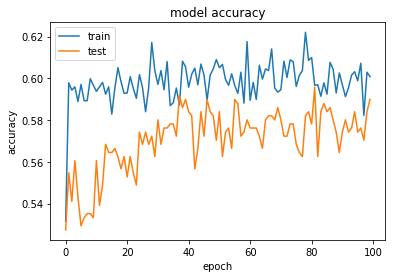

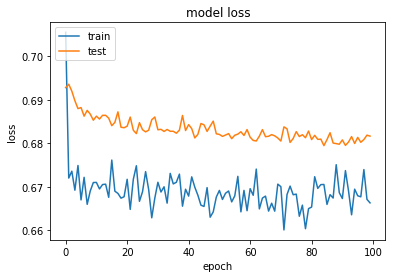

In [56]:
Baseline.validation_accuracy_loss(h_clf)

In [ ]:
name = 'baseline_classification_100epoch_16steps(eclipse)'
save_model(similarity_model, name)
save_result(h, name)